In [23]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/CreditScore/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 cs-test.csv	     'Data Dictionary.xls'   Test_Set.xlsx
 cs-training.csv      GiveMeSomeCredit.zip   Training_Set.xlsx
 cs-training.gsheet   sampleEntry.csv


In [24]:
import os
os.chdir("/content/drive/My Drive/CreditScore/")
os.getcwd()

'/content/drive/My Drive/CreditScore'

**Import Data and Moduls**

In [0]:
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# visual libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [0]:
data=pd.read_excel(r'/content/drive/My Drive/CreditScore/Training_Set.xlsx')
data_test=pd.read_excel(r'/content/drive/My Drive/CreditScore/Test_Set.xlsx')

In [0]:
# trainng data
df=pd.DataFrame(data)
# test data
df_test=pd.DataFrame(data_test)
#df.head()

In [28]:
df = df[['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'Income', 'Dependents']]
df_test = df_test[['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'Income', 'Dependents']]
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,Income,Dependents
0,1,0.766127,45.0,2,0.802982,13.0,0,6,0,9120.000000,2
1,0,0.957151,40.0,0,0.121876,4.0,0,0,0,2600.000000,1
2,0,0.658180,38.0,1,0.085113,2.0,1,0,0,3042.000000,0
3,0,0.233810,30.0,0,0.036050,5.0,0,0,0,3300.000000,0
4,0,0.907239,49.0,1,0.024926,7.0,0,1,0,24142.521406,0


Downsample Majority class to Match Minority class

In [29]:
n_class0=len(df[df['SeriousDlqin2yrs']==0].index)
n_class1=len(df[df['SeriousDlqin2yrs']==1].index)

print('Granted class',n_class0,'NonGranted',n_class1)

Granted class 139628 NonGranted 9862


Text(0, 0.5, 'Frequency')

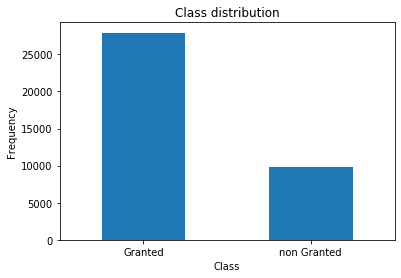

In [30]:
# Lets shuffle the data before creating the subsamples
df = df.sample(frac=1)

non_Granted = df[df['SeriousDlqin2yrs'] == 1]
Granted = df[df['SeriousDlqin2yrs'] == 0][:int(n_class0*0.20)]   # choose portion of large class

new_df = pd.concat([non_Granted, Granted])
# Shuffle dataframe rows
new_df = new_df.sample(frac=1, random_state=42)
# Let's plot the Transaction class against the Frequency
labels = ['Granted','non Granted']
classes = pd.value_counts(new_df['SeriousDlqin2yrs'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [0]:
# prepare the data (feature and label arrays)
features = new_df.drop(['SeriousDlqin2yrs'], axis = 1)
labels = pd.DataFrame(new_df['SeriousDlqin2yrs'])

feature_array = features.values
label_array = labels.values
#features.head()
#labels.head()

#**Scaling the Data**

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_scaled=pd.DataFrame(scaler.fit_transform(feature_array))
x_scaled.columns = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'Income', 'Dependents']
y=labels
#x_scaled.head()

In [0]:
# splitting the faeture array and label array keeping 80% for the trainnig sets
X_train,X_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.20)

For this particular problem, I want to use the model which gives the highest accuracy. Let’s use train and test sets and measure the accuracy of different models

In [0]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("NN",MLPClassifier()))

#measure the accuracy
cv_result =[]
model_name=[]
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result.append(cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy"))
    model_name.append(name)

In [35]:
list0 = []
for i in range(len(cv_result)):
  list0.append((model_name[i], cv_result[i].mean()))
list0=pd.DataFrame(list0)
list0.columns = ['Model', 'Accuracy']
print(list0)

   Model  Accuracy
0     LR  0.820867
1     NB  0.821893
2     RF  0.818982
3    SVC  0.820040
4  Dtree  0.747130
5    XGB  0.827550
6    KNN  0.792286
7     NN  0.825135


From this result, we see that XGB and NN are the best performing one (~80% accuracy). But for improving it further, we’ll do Hyperparameter Tuning (I just do for XGB)

In [36]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.83
Accuracy of XGB classifier on test set: 0.84


In [37]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8283766694327215)

In [40]:
# apply best Hyperparameter on model
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=3).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.83
Accuracy of XGB classifier on test set: 0.84


Now we apply our model on test data set to predict our classes

In [0]:
# Scaling test set
x_test_scaled=pd.DataFrame(scaler.fit_transform(df_test))
x_test_scaled.columns = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'Income', 'Dependents']

# predict 
y_predict=xgb_model.predict_proba(x_test_scaled)
prediction=pd.DataFrame(y_predict[:,1])
prediction.columns=['probablity']
prediction

# save output file
path=r'Prediction_results.xlsx'
writer=pd.ExcelWriter(path)
prediction.to_excel(writer, index=False)
writer.save()